## 1D Model

In [310]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import torch
from botorch.models import SingleTaskGP, ModelListGP
from botorch.fit import fit_gpytorch_model
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.analytic import UpperConfidenceBound, ProbabilityOfImprovement
from botorch.optim import optimize_acqf
from botorch.cross_validation import gen_loo_cv_folds
from botorch.posteriors.gpytorch import GPyTorchPosterior
import math
import GPy

## Identify and plot the objective function

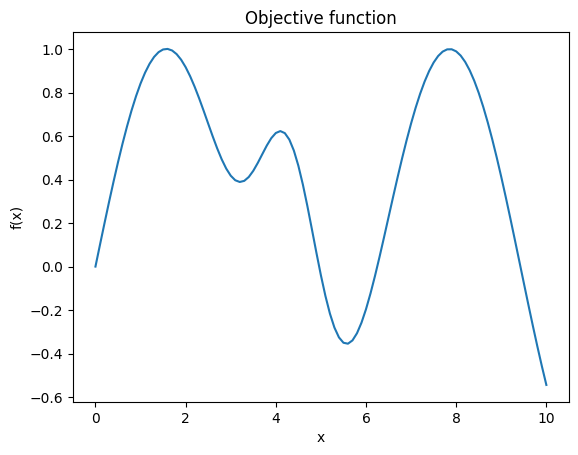

In [311]:
def F(X):
    y = []
    for x in X:
        y.append(np.sin(x) + 1.5 * np.exp(-(x - 4.3) ** 2))
    return torch.tensor(y)

x = np.linspace(0,10,101)
y = F(x)
plt.plot(x,y)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Objective function")
plt.show()

## Retrive initial dataset

(tensor([[9.8337],
         [8.7628],
         [2.6147],
         [3.5166],
         [2.4962],
         [5.2021],
         [9.6656],
         [3.3591],
         [4.9692],
         [3.6835]]),
 tensor([[-0.3976],
         [ 0.6147],
         [ 0.5905],
         [ 0.4457],
         [ 0.6595],
         [-0.2177],
         [-0.2385],
         [ 0.4031],
         [-0.0086],
         [ 0.5099]]),
 0.659471869468689)

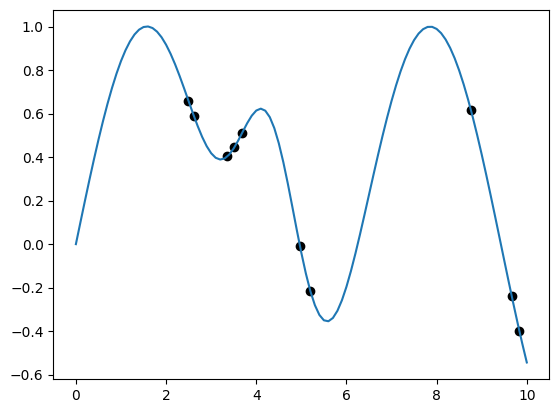

In [312]:
n = 10 # Number of training points
train_x = torch.rand(n,1)*10
train_y = F(train_x).unsqueeze(-1)
best_observed = train_y.max().item()
plt.plot(train_x,train_y,'o', color = 'black')
plt.plot(x,F(x))
plt.show
train_x,train_y,best_observed

## Fit GP model

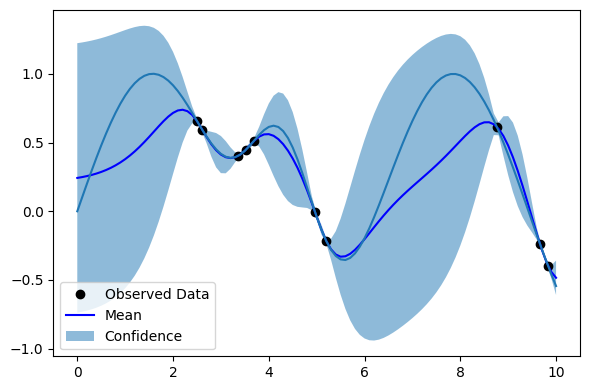

In [313]:
model = SingleTaskGP(train_x,train_y)
mll = ExactMarginalLogLikelihood(model.likelihood,model)
fit_gpytorch_model(mll)

# Plot results
model.eval()

# Initialize plot
f,ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 10]
test_x = torch.linspace(0, 10, 101)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_x)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'ko')
    # Plot posterior means as blue line
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    plt.plot(x,F(x))
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()
plt.show()

## Acquistion function

In [314]:
EI = qExpectedImprovement(
    model = model,
    best_f = best_observed
)

## Optimise acquisition function

In [315]:
candidates_x,_ = optimize_acqf(
    acq_function = EI,
    bounds = torch.tensor([[0.],[10.]]),
    q = 10, # Number of suggested candidates
    num_restarts = 200,
    raw_samples = 512
)
candidates_x
candidates_y = F(candidates_x).unsqueeze(-1)

candidates_x,candidates_y

(tensor([[4.2059],
         [1.5397],
         [7.2679],
         [0.0000],
         [8.2454],
         [2.2110],
         [7.8077],
         [1.9228],
         [1.0757],
         [0.5051]]),
 tensor([[6.1231e-01],
         [1.0003e+00],
         [8.3335e-01],
         [1.3995e-08],
         [9.2437e-01],
         [8.2109e-01],
         [9.9894e-01],
         [9.4396e-01],
         [8.7995e-01],
         [4.8391e-01]]))

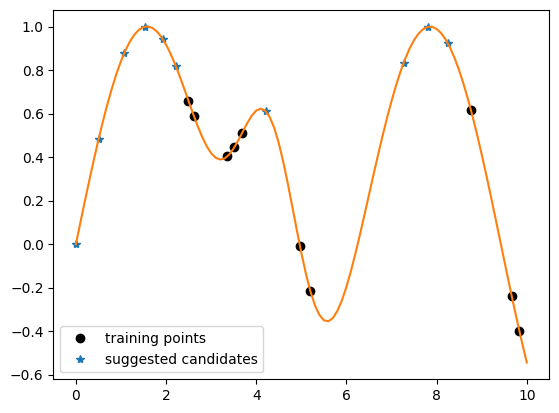

In [316]:
plt.plot(train_x,train_y,'o', color = 'black')
plt.plot(candidates_x,candidates_y,'*')
plt.legend(['training points','suggested candidates'])
plt.plot(x,F(x))
plt.show()

## Take in suggested data, forming new training dataset

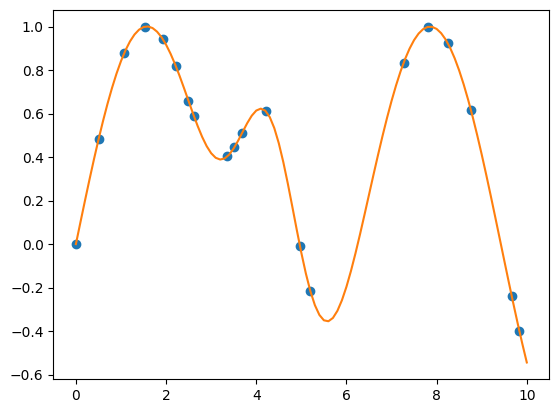

In [317]:
combine_x = (train_x,candidates_x)
combine_y = (train_y,candidates_y)
posterior_x = torch.cat(combine_x, dim = 0)
posterior_y = torch.cat(combine_y, dim = 0)
posterior_x,posterior_y
plt.plot(posterior_x,posterior_y,'o')
plt.plot(x,F(x))

## Posterior model

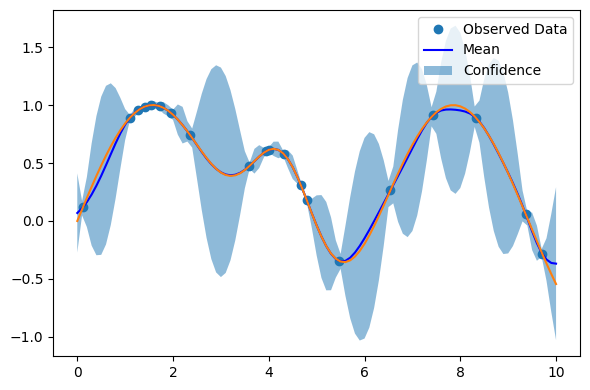

In [300]:
posterior_model = SingleTaskGP(posterior_x,posterior_y,)
mll = ExactMarginalLogLikelihood(posterior_model.likelihood,model)
fit_gpytorch_model(mll)

# Plot
posterior_model.eval()
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 10]
test_x = torch.linspace(0, 10, 101)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = posterior_model.posterior(test_x)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(posterior_x.cpu().numpy(), posterior_y.cpu().numpy(), 'o',)
    # Plot posterior means as blue line
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    plt.plot(x,F(x))
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()
plt.show()

## Second run

In [303]:
EI = qExpectedImprovement(
    model = posterior_model,
    best_f = best_observed
)

In [304]:
candidates_x,_ = optimize_acqf(
    acq_function = EI,
    bounds = torch.tensor([[0.],[10.]]),
    q = 10, # Number of suggested candidates
    num_restarts = 200,
    raw_samples = 512
)
candidates_x
candidates_y = F(candidates_x).unsqueeze(-1)

candidates_x,candidates_y

(tensor([[8.6907],
         [8.0371],
         [8.8083],
         [5.1790],
         [2.9083],
         [7.8882],
         [3.9184],
         [8.5700],
         [7.1103],
         [7.7340]]),
 tensor([[ 0.6699],
         [ 0.9833],
         [ 0.5782],
         [-0.2004],
         [ 0.4474],
         [ 0.9994],
         [ 0.5957],
         [ 0.7544],
         [ 0.7365],
         [ 0.9928]]))

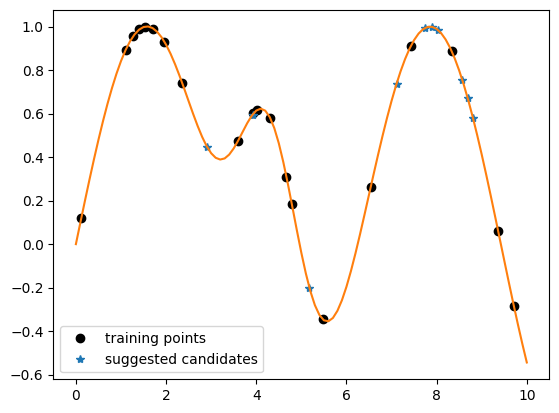

In [305]:
plt.plot(posterior_x,posterior_y,'o', color = 'black')
plt.plot(candidates_x,candidates_y,'*')
plt.legend(['training points','suggested candidates'])
plt.plot(x,F(x))
plt.show()

In [ ]:
combine_x = (posterior_x,candidates_x)
combine_y = (posterior_y,candidates_y)
posterior_x = torch.cat(combine_x, dim = 0)
posterior_y = torch.cat(combine_y, dim = 0)
posterior_x,posterior_y
plt.plot(posterior_x,posterior_y,'o')
plt.plot(x,F(x))

In [ ]:
posterior_model = SingleTaskGP(posterior_x,posterior_y,)
mll = ExactMarginalLogLikelihood(posterior_model.likelihood,model)
fit_gpytorch_model(mll)

# Plot
posterior_model.eval()
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 10]
test_x = torch.linspace(0, 10, 101)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = posterior_model.posterior(test_x)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(posterior_x.cpu().numpy(), posterior_y.cpu().numpy(), 'o',)
    # Plot posterior means as blue line
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    plt.plot(x,F(x))
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()
plt.show()